## Project : Finding the factors influencing the SAT scores_NYC High School Data

### Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("{0}".format(f))
    data[f.replace(".csv", "")] = d

### Read in the surveys

In [2]:
all_survey = pd.read_csv("survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

### Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

### Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


### Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
print(survey_fields)

['rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']


In [12]:
print(type(correlations))

<class 'pandas.core.series.Series'>


In [13]:
corr_survey = correlations.loc[survey_fields]

print(corr_survey)

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64


In [14]:
import matplotlib.pyplot as plt

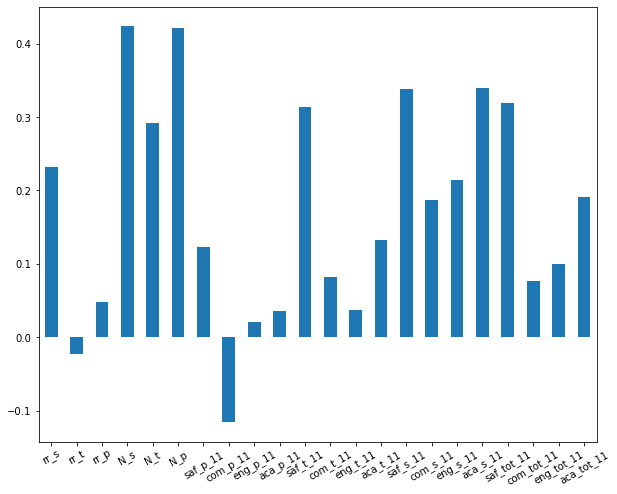

In [15]:
plt.figure(figsize = (10,8))

plt.subplot(1,1,1)

corr_survey.plot.bar()
plt.xticks(rotation = 30)
plt.show()

#### Findings of the Correlation Analysis

The correlation is high (close to or more than .3) in the following cases
1. N_s, N_p, which indicates the total number of responses
2. Safety Score indicators by teachers and students
3. High Engagment indicator
4. High Academic inclination

In this case, the surprising finding is that schools that are considered safer are highly correlated with SAT scores. 

#### We will further explore the safety indicator variables saf_p_11 and saf_t_11 via scatterplots

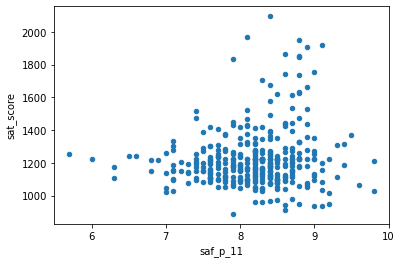

In [16]:
combined.plot.scatter('saf_p_11', 'sat_score')
plt.show()


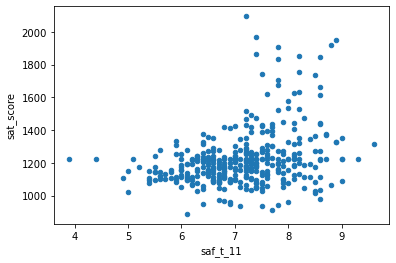

In [17]:
combined.plot.scatter('saf_t_11', 'sat_score')
plt.show()

#### The scatter plots indicate a high correlation between safety scores and SAT scores

#### Next we will aggregate the safety scores by borough / neighborhood, and analyze if schools in safer neighborhoods have higher SAT Scores

In [18]:
print(combined.columns)

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'priority05', 'priority06', 'priority07', 'priority08', 'priority09',
       'priority10', 'Location 1', 'lat', 'lon', 'school_dist'],
      dtype='object', length=160)


In [19]:
for col in sorted(combined.columns):
    #if 'bor' in col:
    print(col)
    

AP Test Takers 
AVERAGE CLASS SIZE
Advanced Regents - % of cohort
Advanced Regents - % of grads
Advanced Regents - n
CSD
Cohort
DBN
Demographic
Dropped Out - % of cohort
Dropped Out - n
Local - % of cohort
Local - % of grads
Local - n
Location 1
NUMBER OF SECTIONS
NUMBER OF STUDENTS / SEATS FILLED
N_p
N_s
N_t
Name
Num of SAT Test Takers
Number of Exams with scores 3 4 or 5
Regents w/o Advanced - % of cohort
Regents w/o Advanced - % of grads
Regents w/o Advanced - n
SAT Critical Reading Avg. Score
SAT Math Avg. Score
SAT Writing Avg. Score
SCHOOL NAME
SCHOOLWIDE PUPIL-TEACHER RATIO
SIZE OF LARGEST CLASS
SIZE OF SMALLEST CLASS
School Name
SchoolName
Still Enrolled - % of cohort
Still Enrolled - n
Total Cohort
Total Exams Taken
Total Grads - % of cohort
Total Grads - n
Total Regents - % of cohort
Total Regents - % of grads
Total Regents - n
aca_p_11
aca_s_11
aca_t_11
aca_tot_11
addtl_info1
addtl_info2
advancedplacement_courses
asian_num
asian_per
black_num
black_per
boro
building_code
bus

In [20]:
boro_scores = combined.groupby('boro').agg(numpy.mean)[['sat_score','saf_t_11', 'saf_p_11']]
boro_scores = boro_scores.reset_index()
print(boro_scores.head())

            boro    sat_score  saf_t_11  saf_p_11
0          Bronx  1157.598203  7.026882  8.346237
1       Brooklyn  1181.364461  6.985849  8.036792
2      Manhattan  1278.331410  7.287778  8.288889
3         Queens  1286.753032  7.365625  8.098437
4  Staten Island  1382.500000  7.210000  7.800000


In [21]:
print(boro_scores.shape)

(5, 4)


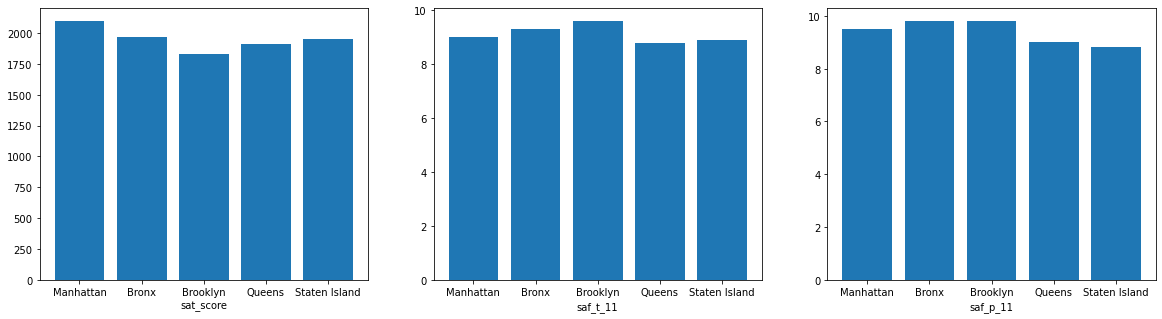

In [22]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize = (20,5))

ax1.bar(combined['boro'], combined['sat_score'])
#ax1.legend().set_visible(False)
ax1.set_xlabel('sat_score')

ax2.bar(combined['boro'], combined['saf_t_11'])
#ax2.legend().set_visible(False)
ax2.set_xlabel('saf_t_11')

ax3.bar(combined['boro'], combined['saf_p_11'])
#ax3.legend().set_visible(False)
ax3.set_xlabel('saf_p_11')


plt.show()

#### It looks like Manhattan and Queens tend to have lower safety scores, whereas Brooklyn has higher safety scores. It is interesting to note that the average SAT score for Brooklyn is lower than low safety areas. We cannot however conclude SAT score comparision between Boros based on safety scores. Hence we will focus on other factors



### Exploring the relationship between race and SAT scores

In [23]:
# The columns containing race proportions are mentioned below

race_cols = ['white_per' , 'asian_per' , 'black_per' , 'hispanic_per']

correlations_race = correlations.loc[race_cols]

print(correlations_race)

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64


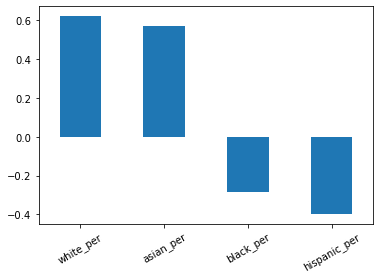

In [24]:
correlations_race.plot.bar()
plt.xticks(rotation = 30)
plt.show()

#### We can observe that there is a positive correlation w.r.t. the White and Asian percentages while there is a negative correlation w.r.t. Black and Hispanic percentages. We will explore the high negative correlation with Hispanice percentage

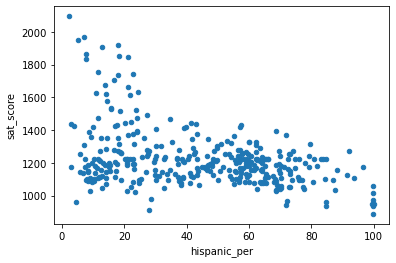

In [25]:
combined.plot.scatter('hispanic_per', 'sat_score')
plt.show()

#### We can observe that schools with a low hispanic proportion(less than 20%) have very high SAT scores relative to scores with high hispanic proportion. Also, most of the scores are between 1000 and 1400. Scools with near 100% hispanic proportions have scores less than 1100.

In [26]:
def extract_combined_hisp(per, direction):
    combined_hisp_greater = combined[combined['hispanic_per'] > per]
    combined_hisp_lesser = combined[combined['hispanic_per'] < per]
    if direction == 'greater_than':
        return combined_hisp_greater
    else:
        return combined_hisp_lesser    

In [27]:
hisp_greater_95 = extract_combined_hisp(95,'greater_than')

In [28]:
print(hisp_greater_95.shape)

(8, 160)


In [29]:
print(hisp_greater_95['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


#### The schools listed above appear to primarily serve recent immigrants to the U.S. These schools have many students who are learning English, which would explain the lower SAT scores.



In [30]:
hisp_less_than_10 = extract_combined_hisp(10,'less_than')

In [31]:
hisp_less_than_10.shape

(30, 160)

In [32]:
hisp_less_than_10_and_sat_1800 = hisp_less_than_10[hisp_less_than_10['sat_score'] > 1800]

In [33]:
print(hisp_less_than_10_and_sat_1800['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


#### The schools with low hispanic proportions and high SAT schools are Elite High Schools and also focused on Technical Education. Though this may not explain the relation between Hispanic proportion and score but their high scores could be explained by the fact that they have an entrance based admission and have students who already did well in a standardized test.

### Exploring the relationship between Gender and SAT Scores

In [34]:
gender_cols = ['male_per', 'female_per']

gender_corr = correlations[gender_cols]

print(gender_corr)

male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64


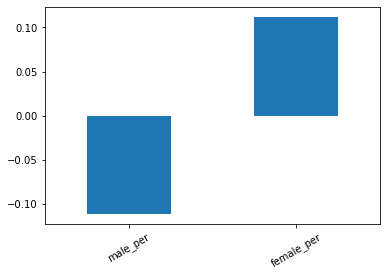

In [35]:
gender_corr.plot.bar()
plt.xticks(rotation = 30)
plt.show()

#### Thus we can observe that there is a positive correlation between female percentage and SAT Scores. 

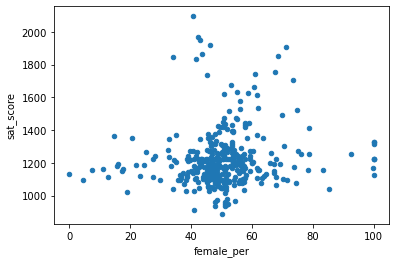

In [36]:
combined.plot.scatter('female_per', 'sat_score')
plt.show()

#### Based on the scatter plot, there doesn't seem to be any real correlation between sat_score and female_per. (A value of .11 was lower than the conventional threshold of 0.3 to begin with)
#### However, there is a cluster of schools with a high percentage of females (60 to 80) and high SAT scores.

In [37]:
bool_high_sat_female = (combined['sat_score'] > 1700) & (combined['female_per'] > 60)
high_sat_female = combined[bool_high_sat_female]

print(high_sat_female['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


#### These schools seem to be very selective high schools with a focus on preparing students for college entrances.

### Exploring the relationship between AP test taker proportions and SAT scores

In [38]:
## Creating a separate column for AP test taker percentage of total enrollment

combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

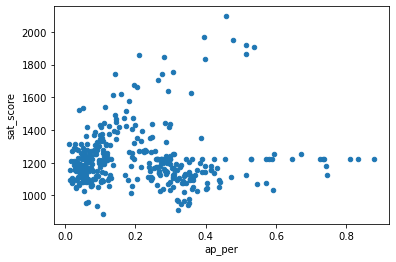

In [39]:
### Creating a scatter plot between AP test taker percentage and SAT scores

combined.plot.scatter('ap_per', 'sat_score')
plt.show()

In [40]:
### Checking the actual correlation value

ap_per_sat_score_corr = combined.corr()['sat_score'].loc['ap_per']
print(ap_per_sat_score_corr)

0.05717081390766952


#### Based on the scatter plot, we observe there is some correlation but it is not a very strong one. 

## Conclusions:
    - The following are indicators of high SAT scores:
        a) Safety scores by Students
        b) Saftey scores by Teachers
        c) Racial Proportions - White / Asian could indicate high SAT scores, while Black/Hispanic would indicate low SAT scores
        d) Gender is not a very strong indicator
        e) The exceptions to the Racial Proportion indicators or Gender indicators are schools with high technical focus or with an admission criteria that involves a difficult standardized test.  